In [2]:
import random
import numpy as np
import requests
from io import BytesIO
from PIL import Image, ImageFile
from os import path, getcwd, listdir, environ
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras import Model, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense, BatchNormalization
from tensorflow.keras.layers import GlobalAveragePooling2D

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import InceptionV3

%matplotlib inline

In [3]:
def read_img(file_loc):
    img = Image.open(file_loc)
    return img


In [20]:
def print_random_images():
    fig=plt.figure(figsize=(10, 10))
    columns = 4
    rows = 4
    title = ""
    
    for i in range(1, columns * rows +1):
        cat = random.choice(breeds)
        dir_path = path.join(data_dir, cat)
        loc = path.join(dir_path, random.choice(listdir(dir_path)))
        img = read_img(loc)
            
        axes = fig.add_subplot(rows, columns, i)
        fig.tight_layout(pad=1.0)
        axes.axis('off')
        title = ""
    
        plt.imshow(img)
        
    plt.show()

In [21]:
def plot_loss(history):
    plt.plot(history.history['loss'], label='loss')
    plt.plot(history.history['val_loss'], label = 'val_loss')
    plt.xlabel('Epoch')
    plt.ylabel('loss')

In [22]:
def plot_accuracy(history):
    plt.plot(history.history['accuracy'], label='accuracy')
    plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(loc='lower right')

In [44]:
def predict_breed(loc):
    key_list = list(train_generator.class_indices.keys())
    response = requests.get(loc)
    img = Image.open(BytesIO(response.content))
    
    img = img.resize((299, 299))
    img = np.array(img) / 255
    
    pred = np.argmax(model.predict(img.reshape(1, 299, 299, 3)), axis=1)
    plt.title(key_list[int(pred)])
    plt.axis('off')
    plt.imshow(img)

In [24]:
data_dir = r'Images'

breeds = listdir(data_dir) # filenames of all the breeds

seed = 42
img_size = 299
batch_size = 32

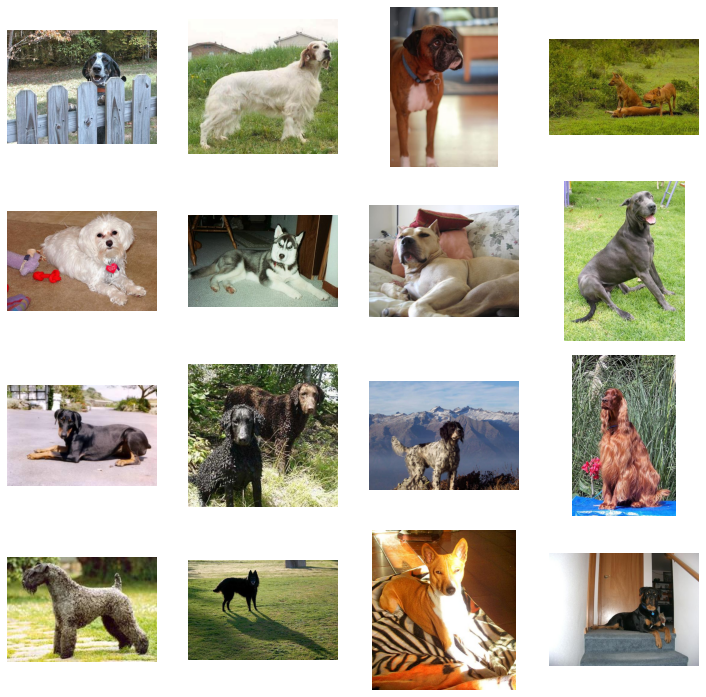

In [25]:
print_random_images()


In [26]:
datagen = ImageDataGenerator(rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.2)

train_generator = datagen.flow_from_directory(
    data_dir,
    target_size=(img_size, img_size),
    batch_size=batch_size,
    class_mode='categorical',
    subset='training',
    seed=seed)

validation_generator = datagen.flow_from_directory(
    data_dir,
    target_size=(img_size, img_size),
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation',
    seed=seed)


Found 16508 images belonging to 120 classes.
Found 4072 images belonging to 120 classes.


In [27]:
train_generator.class_indices


{'n02085620-Chihuahua': 0,
 'n02085782-Japanese_spaniel': 1,
 'n02085936-Maltese_dog': 2,
 'n02086079-Pekinese': 3,
 'n02086240-Shih-Tzu': 4,
 'n02086646-Blenheim_spaniel': 5,
 'n02086910-papillon': 6,
 'n02087046-toy_terrier': 7,
 'n02087394-Rhodesian_ridgeback': 8,
 'n02088094-Afghan_hound': 9,
 'n02088238-basset': 10,
 'n02088364-beagle': 11,
 'n02088466-bloodhound': 12,
 'n02088632-bluetick': 13,
 'n02089078-black-and-tan_coonhound': 14,
 'n02089867-Walker_hound': 15,
 'n02089973-English_foxhound': 16,
 'n02090379-redbone': 17,
 'n02090622-borzoi': 18,
 'n02090721-Irish_wolfhound': 19,
 'n02091032-Italian_greyhound': 20,
 'n02091134-whippet': 21,
 'n02091244-Ibizan_hound': 22,
 'n02091467-Norwegian_elkhound': 23,
 'n02091635-otterhound': 24,
 'n02091831-Saluki': 25,
 'n02092002-Scottish_deerhound': 26,
 'n02092339-Weimaraner': 27,
 'n02093256-Staffordshire_bullterrier': 28,
 'n02093428-American_Staffordshire_terrier': 29,
 'n02093647-Bedlington_terrier': 30,
 'n02093754-Border_terr

In [29]:
base_model = InceptionV3(input_shape=(img_size, img_size, 3), weights='imagenet', include_top=False)

for layer in base_model.layers:
    layer.trainable = False

x = base_model.output
x = BatchNormalization()(x)
x = GlobalAveragePooling2D()(x)

predictions = Dense(120, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

model.summary()

87916544/87910968 [==============================] - 7s 0us/step
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 149, 149, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 149, 149, 32) 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 149, 149, 32) 0           batch_normalization[0][0]        
_____________________________

In [31]:
model.compile(optimizer=Adam(1e-4), loss='categorical_crossentropy',metrics=['accuracy'])


In [33]:
history = model.fit(
  train_generator,
  validation_data=validation_generator,
  epochs=2,
  steps_per_epoch=len(train_generator),
  validation_steps=len(validation_generator)
)

Epoch 1/2
516/516 [==============================] - 2015s 4s/step - loss: 1.2683 - accuracy: 0.8155 - val_loss: 0.6404 - val_accuracy: 0.8647
Epoch 2/2
516/516 [==============================] - 1894s 4s/step - loss: 0.5427 - accuracy: 0.8748 - val_loss: 0.4605 - val_accuracy: 0.8767


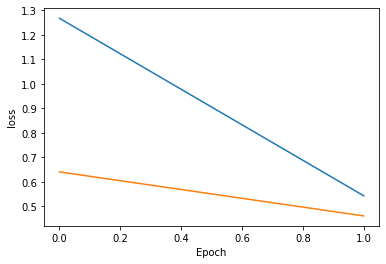

In [34]:
plot_loss(history)


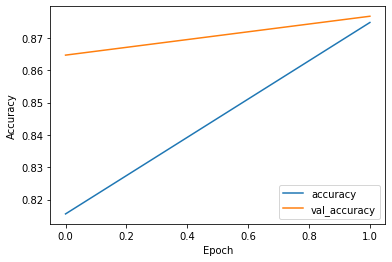

In [35]:
plot_accuracy(history)


In [1]:
predict_breed("Url du chien")

NameError: name 'predict_breed' is not defined